In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sqrt

In [2]:
def ydot(y):
    rvec = y[:2] 
    pvec = y[2:]
    rsq = rvec @ rvec
    r3 = rsq * sqrt(rsq)
    r3inv = 1/r3
    return np.concatenate([pvec,-1 * rvec * r3inv])

In [3]:
# Butcher tableuas for different methods
LobattoIIIB = {
    'a':np.array([
        [1/6, -1/6, 0],
        [1/6, 1/3, 0],
        [1/6, 5/6, 0]
    ]),
    'c':np.array([0, 1/2, 1]),
    'b':np.array([1/6, 2/3, 1/6])
}

GL4 = {
    'a':np.array([
        [1/4, 1/4-1/6*sqrt(3)],
        [ 1/4+1/6*sqrt(3), 1/4]
    ]),
    'c':np.array([1/2 - 1/6*sqrt(3),1/2 + 1/6*sqrt(3)]),
    'b':np.array([1/2,1/2])
}

GL6 = {
    'a':np.array([
        [5/36,2/9-1/15*sqrt(15),5/36-1/30*sqrt(15)],
        [5/36 + 1/24*sqrt(15),2/9,5/36 - 1/24*sqrt(15)],
        [5/36 + 1/30*sqrt(15),   2/9 + 1/15*sqrt(15),5/36]
    ]),
    'c':np.array([1/2 - 1/10*sqrt(15), 1/2, 1/2 + 1/10*sqrt(15)]),
    'b':np.array([5/18,  4/9,  5/18])
}
methods = {'LobattoIIIB':LobattoIIIB,'GL4':GL4,'GL6':GL6}

In [4]:
def rk4(y,ydot,h,f):
    k1 = ydot
    y2 = y + h/2 * k1
    k2 = f(y2)
    y3 = y + h/2 * k2;
    k3 = f(y3);
    y4 = y + h * k3;
    k4 = f(y4)
    yout = y + 1/6*h*(k1 + 2*k2 + 2*k3 + k4);
    ydotout = f(yout)
    return yout,ydotout

In [22]:
from warnings import warn
machine_eps = np.finfo(np.float64).eps

def rkimplicitstep(f,y,h,a,b,c,max_iter = 20,tol=machine_eps):
    """
    Advance ODE dy/dt = f(y) for input y for a timestep h
    using an implicit Runge-Kutta method defined by the 
    Butcher tableau [a,b,c].
    
    Arguments
    ---------
    f : function
     Vector function of numpy array that returns the
     time derivatives defining the ODE.
    y : ndarray
     Initial condition of ODE
    h : float
      Timestep to advance ODE
    a : ndarray, shape (N,N)
     Butcher tableau entry 'a' for N-stage RK method.
    b : ndarray shape (N,)
     Butcher tableau entry 'b' for N-stage RK method.
    c : ndarray shape (N,)
     Butcher tableau entry 'c' for N-stage RK method.
    max_iter : int, optional
     Maximum number of iterations to compute for 
     root-finding via fixed-point iteration.
     Default is 20
    tol : float, optional
     Tolerance for fixed-point iteration root-finding.
     Default is machine precision.
    """
    
    si1,si2 = a.shape
    sic, = c.shape
    ydottemp = f(y)
    ndim, = y.shape
    ydot = np.zeros((sic,ndim))

    for i,ci in enumerate(c):
        if ci == 0:
            ydot[i,:] = ydottemp
        else:
            ytemp,ydtemp = rk4(y,ydottemp,ci*h,f)
            ydot[i,:] = ydtemp

    delk = 1
    itr = 0 
    for itr in range(max_iter):
        ydot_old = ydot.copy()
        for i in range(si1):
            ytemp = y.copy()
            for j in range(si2):
                ytemp = ytemp + h * a[i,j] * ydot[j,:]
            ydot[i,:] = f(ytemp)
        if np.alltrue( np.abs(ydot - ydot_old) < tol * np.abs(ydot_old) ):
            break
    else:
        warn("'rkimplicitstep' reached maximum number of iterations ({})".format(max_iter))
    for i in range(si1):
        y += h * b[i] * ydot[i,:]
    return y,ydot,itr

In [23]:
e = 0.3;
y0 = np.array([1+e, 0, 0, np.sqrt((1-e)/(1+e))]);
ydot0 = ydot(y0)

In [24]:
def Energy(y):
    rvec = y[:2] 
    pvec = y[2:]
    rsq = rvec @ rvec
    r = np.sqrt(rsq)
    return 0.5 * pvec @ pvec - 1/r 

In [25]:
N = 35
hsteps = 2*np.pi * np.logspace(-2.5,-.5,N)
dEbyE_dict = {method:np.zeros(N) for method in methods.keys()}
for method,tableau in methods.items():
    dEbyE = dEbyE_dict[method]
    for i,h in enumerate(hsteps):
        Nstep = int(np.ceil(2 * np.pi * 2 / h))
        y0 = np.array([1+e, 0, 0, np.sqrt((1-e)/(1+e))])
        E0 = Energy(y0)
        for _ in range(Nstep):
            y0,_,_ = rkimplicitstep(ydot,y0,h,tableau['a'],tableau['b'],tableau['c'],tol=1e-15,max_iter=25)
        Ef = Energy(y0)
        dEbyE[i] = np.abs((Ef - E0) / E0)

/Users/shadden/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: 'rkimplicitstep' reached maximum number of iterations (25)


3.4498346128112773

(1e-16, 99.91988011734433)

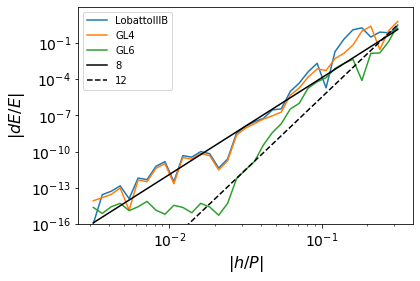

In [35]:
for method,dEbyE in dEbyE_dict.items():
    plt.loglog(hsteps/(2 *np.pi),dEbyE,label=method)
plt.legend()    
plt.ylabel(r'$|dE/E|$',fontsize=16)
plt.xlabel(r'$|h/P|$',fontsize=16)
plt.tick_params(labelsize=14)
p = 8
xplot = hsteps/(2 *np.pi)
y0plot = dEbyE_dict['LobattoIIIB'][N//2]/xplot[N//2]**p 
yplot = y0plot * (xplot)**p
plt.loglog(xplot,yplot,label=p,color='k')

p = 12
xplot = hsteps/(2 *np.pi)
y0plot = dEbyE_dict['GL6'][N//2]/xplot[N//2]**p 
yplot = y0plot * (xplot)**p
plt.loglog(xplot,yplot,'k--',label=p)
plt.legend()    
plt.ylim(ymin=1e-16)